In [1]:
import collections, math, os, sys
sys.path.insert(0, '../../../../FISH-annotation/Annotation')
from SpotAnnotationAnalysis import SpotAnnotationAnalysis
from QuantiusAnnotation import QuantiusAnnotation
from sklearn.neighbors import KDTree
from matplotlib.lines import Line2D
import util
import pandas as pd
import matplotlib.pyplot as plt

# SNR vs. NND
Scatter and strip plots to compare the effects of SNR and NND on detection.
Using the "Fig 2b" dataset.

In [2]:
density_list = [0.0025, 0.0027, 0.003, 0.0037, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009]
clustering_params = ['AffinityPropagation', -350]
correctness_threshold = 4
declumping_params = ['KMeans', 2]
height = 300
cwd = os.getcwd()

## Scatter Plot

In [3]:
data = []
json_paths = [cwd + '/anno/Fig2B.json',
              cwd + '/anno/Fig2B_inv.json']

# for each file
for json_path in json_paths:
    
    # for each image
    for density in density_list:
        print(density)
        
        if(json_path == json_paths[0]):
            img_name = 'snr_9_1_density_' + str(density) + '_spot_img.png'
            img_path = cwd + '/spot_images/og/' + img_name
        else:
            img_name = 'snr_9_1_density_' + str(density) + '_spot_img_inv.png'
            img_path = cwd + '/spot_images/inv/' + img_name
        
        csv_path = cwd + '/spot_data/' + 'snr_9_1_density_' + str(density) + '_coord_snr_list.csv'
        
        """ Get cluster centroids """
        qa = QuantiusAnnotation(json_path, img_name)
        anno_all = qa.df()
        sa = SpotAnnotationAnalysis(qa)

        clusters = sa.get_clusters(anno_all, clustering_params)
        cluster_size_threshold = util.get_cluster_size_threshold(clusters)
        small_clusters, large_clusters = util.sort_clusters_by_size(clusters, cluster_size_threshold)
        clumpiness_threshold = util.get_clumpiness_threshold(large_clusters)
        clumpy_clusters, nonclumpy_clusters = util.sort_clusters_by_clumpiness(large_clusters, clumpiness_threshold)
        result_clusters = nonclumpy_clusters
        for i in range(len(clumpy_clusters.index)):
            subclusters = util.declump(clumpy_clusters, i, declumping_params)
            result_clusters = pd.concat([subclusters, result_clusters], ignore_index=True)

        """ Count up num_spots_detected, num_spots_total at each SNR """
        result_points = result_clusters.loc[:, ['centroid_x', 'centroid_y']].as_matrix()
        result_kdt = KDTree(result_points, leaf_size=2, metric='euclidean')
        
        ref_df = pd.read_csv(csv_path)
        ref_points = ref_df.loc[:, ['col', 'row']].as_matrix()
        ref_snrs = ref_df.loc[:, ['snr']].as_matrix()
        ref_kdt = KDTree(ref_points, leaf_size=2, metric='euclidean')
        

        # for each spot in the image
        for ref_point, ref_snr in zip(ref_points, ref_snrs):
            dist, ind = ref_kdt.query([ref_point], k=2)
            ref_nnd = dist[0][1]
            ref_snr = ref_snr[0]
            
            dist, ind = result_kdt.query([[ref_point[0], height-ref_point[1]]], k=1)
            if dist[0][0] <= correctness_threshold:
                color = 'green'
            else:
                color = 'magenta'
            
            data.append((ref_nnd, ref_snr, color))

0.0025
0.0027
0.003
0.0037
0.004
0.005
0.006
0.007
0.008
0.009
0.0025
0.0027
0.003
0.0037
0.004
0.005
0.006
0.007
0.008
0.009


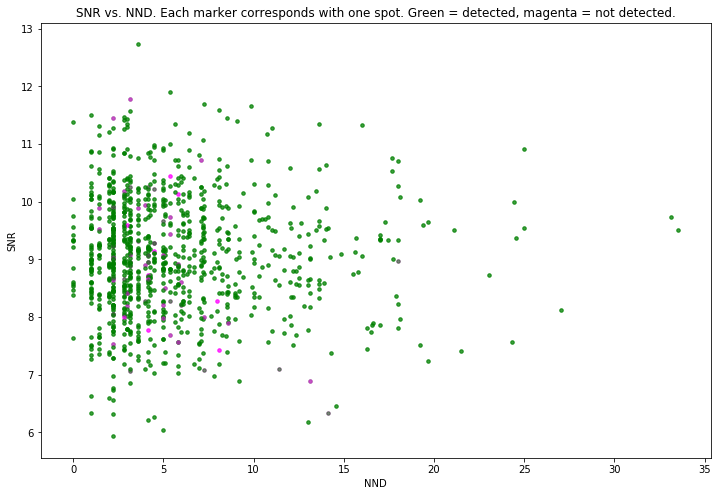

In [4]:
fig = plt.figure(figsize = (12,8))
for ref_nnd, ref_snr, color in data:
    plt.scatter([ref_nnd], [ref_snr], color=color, alpha=0.5, s=12)
plt.xlabel('NND')
plt.ylabel('SNR')
plt.title('SNR vs. NND. Each marker corresponds with one spot. Green = detected, magenta = not detected.')
plt.show()

## Strip Plot

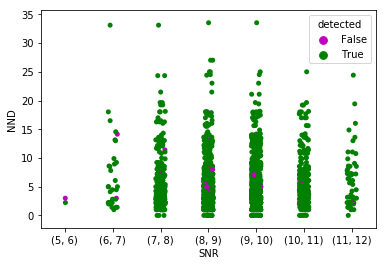

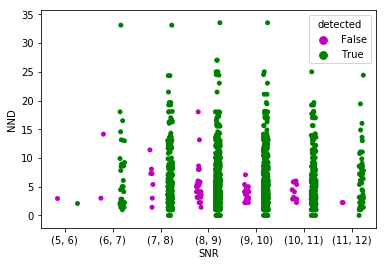

In [13]:
import sys
sys.path.append('/usr/local/lib/python3.6/site-packages')
import seaborn as sns

nnd_list, snr_list, detected_list = [], [], []

snr_bins = [(x, y) for x, y in zip(range(5, 12, 1), range(6, 13, 1)) ] 

for ref_nnd, ref_snr, color in data:
    nnd_list.append(ref_nnd)
    detected_list.append(color=='green')

for ref_nnd, ref_snr, color in data:
    for i in range(len(snr_bins)):
        low, high = snr_bins[i]
        if (ref_snr > low and ref_snr <= high):
            snr_list.append(str(snr_bins[i]))
snr_list += [str(snr_bins[2]), str(snr_bins[2])]
    
d = {'SNR':snr_list,'NND':nnd_list, 'detected':detected_list}
df = pd.DataFrame(d)

snr_bins_list = [str(x) for x in snr_bins] 
sns.stripplot(x="SNR", y="NND", data=df, order=snr_bins_list, hue="detected", jitter=True, palette=sns.color_palette(['m','g']))
plt.show()
sns.stripplot(x="SNR", y="NND", data=df, order=snr_bins_list, hue="detected", jitter=True, palette=sns.color_palette(['m','g']), dodge=True)
plt.show()